# Machine Learning Mini-project | CIOCARLAN Alina & PYTHOUD Axel
## Binary classification

This project consists in building a binary classification workflow. We decided to base our classification workflow on deep learning techniques. We will apply this workflow on the Chronic Kidney Diseases dataset and on the Banknote one.

## 1. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype
import os.path
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

## 2. Pre-processing functions

In [2]:
## File modification
# This aims to standardize the two files so they can be preprocessed in the same way.

def hf_add_definitions(input_file_name, output_file_name, definition) :  # Axel PYTHOUD
    input_file = open(input_file_name,"r")
    text = definition + "\n" + input_file.read()
    input_file.close()
    
    output_file = open(output_file_name, "w")
    output_file.write(text)
    output_file.close()
    
    
def hf_remove_characters(text, characters) :  # Axel PYTHOUD
    
    for character in characters : 
        text = text.replace(character,'')
    
    return text

def hf_remove_id(input_file_name) :  # Axel PYTHOUD
    input_file = open(input_file_name,"r")
    text = ""
    
    for line in input_file : 
        text += line[line.index(',') + 1:]
        
    input_file.close()
    
    return text

def hf_prepare_kidney_file(input_file_name, output_file_name) :  # Axel PYTHOUD
    text = hf_remove_id(input_file_name) #This removes the id column
    text = hf_remove_characters(text, ["\t", "?", ' ']) #This removes tabs, question marks, and spaces from the file
    
    output_file = open(output_file_name, "w")
    output_file.write(text)
    output_file.close()

unprepared_banknote_file_name = "data_banknote_authentication.txt"
banknote_file_name = "data_banknote_authentication_with_def.csv"
if not(os.path.exists(banknote_file_name)) :
    hf_add_definitions(unprepared_banknote_file_name, banknote_file_name, "variance,skewness,curtosis,entropy,class") #This adds a definition to the file

unprepared_kidney_file_name = "archive/kidney_disease.csv"
kidney_file_name = "archive/kidney_disease_cleaned.csv"
if not(os.path.exists(kidney_file_name)) :
    hf_prepare_kidney_file(unprepared_kidney_file_name, kidney_file_name) #This removes tabs, question marks, and spaces from the file
    

## Import the files into pandas dataframes

def import_file(file_name, separator) :     # Axel PYTHOUD
    pd_data = pd.read_csv(file_name, sep = separator)
    return pd_data
    
banknote_pd_data = import_file(banknote_file_name, ",")    
kidney_pd_data = import_file(kidney_file_name, ",")


## Clean dataframes
# Add missing values
# Center and reduce columns

def hf_get_mean_value(column) :  # Axel PYTHOUD
    #Help function that returns the mean value of the column.
    #For non numeric data types, returns the most frequent value.
    if is_numeric_dtype(column) :
        return column.mean()
    else :
        values = pd.value_counts(column)
        return values.idxmax()
        
def drop_column(pd_data):  #Alina CIOCARLAN
    """ Objective : drop columns that have more than 30% of missing values
        Input : dataframe to pre-process (type : pandas dataframe)
        Output : dataframe (type : pandas dataframe)"""
    c = pd_data.columns
    #calculate the percrentage of each column that is empty
    empty = (pd_data.isnull().sum() / len(pd_data)) * 100

    for i in range(len(empty)):
        if empty[i] > 30: #drop column if percentage of missing values is above 30%
            c_to_drop = c[i]
            pd_data = pd_data.drop(c_to_drop, 1)
    return pd_data

        
def clean_dataframe(pd_data) :  # Axel PYTHOUD
    pd_data = drop_column(pd_data)
    
    column_names = pd_data.columns
    number_of_columns = column_names.size
    means = []
    
    for col_name in column_names :
        means.append(hf_get_mean_value(pd_data[col_name]))
       
    # We have the means of each column of the dataset
    # Now we find the cells that are not filled, and replace them with the mean value of the column.
    null_data = np.where(pd.isnull(pd_data))
    for i in range(len(null_data[0])) :
        row = null_data[0][i]
        col_id = null_data[1][i]
        col = column_names[col_id]
        pd_data.at[row,col] = means[col_id]
    
    # Our cells are all filled now.
    # We can center and reduce the values of the numeric columns
    L=list(pd_data.columns)[:-1] #function applied on all numerical values except the last class
    pd_data[L] = pd_data[L].apply(lambda x : (x - x.mean()) / np.sqrt(x.var() + 10**-9) if is_numeric_dtype(x) else x) #The value 10**-9 is a safety to ensure we don't divide by 0.
    
    return pd_data

def label_encoding(pd_df): #Alina CIOCARLAN
    """ Objective : encode the columns that have non-numerical values
        Input : dataframe to pre-process (type : pandas dataframe)
        Output : dictionnary with the labels that were changed into numerical values (type : dictionnary)"""
    c=pd_df.columns
    dict_class=dict()
    types=list(pd_df.dtypes)
    for i in range(len(c)):
        if types[i] == 'O': #there are only 2 types here, if it's of type 'O', we have to transform it into numerical
            lab_encod = LabelEncoder()
             
            pd_df[c[i]] = lab_encod.fit_transform(pd_df[c[i]])
            dict_class[c[i]]=lab_encod.classes_ #keep a dictionnary of the labels to keep track of them if needed
    return dict_class

## 3. Feature selection

We will apply a PCA for this step.

In [3]:
def PCA_on_df(df,seuil): #Alina CIOCARLAN
    """ Objective : Apply PCA to reduce dimension
        Inputs : - dataframe to pre-process (type : pandas dataframe)
                - threshold of the PCA (type : float between 0 and 1)
        Output : transformed dataframe (type : pandas dataframe)"""
    L=list(df.columns)[:-1] # we do not apply the PCA on the column "labels"
    df_pca=df[L]
    pca=PCA()
    pca.fit(df_pca)
    df_pca=pca.transform(df_pca)
    cumulative_pca=pca.explained_variance_ratio_.cumsum()
    n=0
    for e in cumulative_pca: #take the columns that lead to the highest variance ratio
        if e<seuil:
            n+=1
    df_pca = df_pca[:, :n]
    return pd.DataFrame(df_pca)

## 4. Training functions

### a. Split the datasets

In [4]:
# we split the dataset in 2 : one part for training/validation set (we'll do K-fold validation right after),
# the other for test set
def data_split(dataX,dataY,train_ratio): #Alina CIOCARLAN
    """ Objective : Split the dataset in 2
        Inputs : - dataframe to split (type : pandas dataframe)
                - training set ratio (type : float between 0 and 1)
        Outputs : - training feature (type : numpy array)
                    - test feature (type : numpy array)
                    - training labels (type : numpy array)
                    - test labels (type : numpy array) """
    x_train, x_test, y_train, y_test = train_test_split(dataX,dataY , test_size=1 - train_ratio)
 
    return x_train, x_test, y_train, y_test


### b. Fine-tune the model

This step is performed using GridSearch.

In [5]:
def get_best_epoch_batch(x_train, y_train): # Alina CIOCARLAN
    """ Objective : Get the best epoch and batch size with GridSearch
        Inputs : - training features (type : numpy array)
                - training labels (type : numpy array)
        Outputs : - batch size (type : int)
                    - epoch number (type : int) """
    # define the model
    def create_model():
        model=Sequential()
        model.add(Dense(64, input_dim=x_train.shape[1], activation='relu'))
        model.add(BatchNormalization())
        model.add(Dense(16, activation='relu'))
        model.add(Dropout(.15))
        model.add(Dense(1, activation='hard_sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='Nadam', metrics=['accuracy'])
        return model
    
    # gridsearch through Keras wrapper
    model_grid_search = KerasClassifier(build_fn=create_model, verbose=0)

    # grid search parameters
    if x_train.shape[0]<500: #if small dataset, we can perform more grid search and we may need less epochs to converge
        batch_size = [20, 40, 60, 80]
        epochs = [75, 100, 125]
        
    else: #otherwise, perform less gridsearch and take more epoch
        batch_size = [40, 70, 100]
        epochs = [75, 100, 125, 150]   
    
    param_grid = dict(batch_size=batch_size, epochs=epochs)
    
    print("====================================================")
    print("Looking for best epoch number and batch size.......")
    
    grid = GridSearchCV(estimator=model_grid_search, param_grid=param_grid, n_jobs=1) 
    # n_jobs=-1 parallélise les opérations en distribuant les tâches sur les coeurs du GPU. A utiliser seulement si on 
    # a un bon GPU et assez de RAM (j'ai i5 9, 8Go de RAM, et ça a planté). Sinon utiliser n_job=1.
    
    #perform grid search and 5-fold crossval
    grid_result = grid.fit(x_train, y_train)

    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    return grid_result.best_params_['batch_size'],grid_result.best_params_['epochs']


In [6]:
def get_best_optimizer(x_train, y_train): # Alina CIOCARLAN
    """ Objective : Get the best optimizer with GridSearch
        Inputs : - training features (type : numpy array)
                - training labels (type : numpy array)
        Output : best optimizer (type : string) """
    def create_model_opt(optimizer='adam'):
        model=Sequential()
        model.add(Dense(64, input_dim=x_train.shape[1], activation='relu'))
        model.add(BatchNormalization())
        model.add(Dense(16, activation='relu'))
        model.add(Dropout(.15))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        return model
    model_grid_search_opt = KerasClassifier(build_fn=create_model_opt,epochs=100, batch_size=40, verbose=0)

    # grid search parameters
    
    print("====================================================")
    print("Looking for the best optimizer.......")
    
    optimizer_list = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
    param_grid = dict(optimizer=optimizer_list)

    grid = GridSearchCV(estimator=model_grid_search_opt, param_grid=param_grid, n_jobs=1) #perform grid search and K-fold
    # n_jobs=-1 parallélise les opérations en distribuant les tâches sur les coeurs du GPU. A utiliser seulement si on 
    # a un bon GPU et assez de RAM (j'ai i5 9, 8Go de RAM, et ça a planté). Sinon utiliser n_job=1.
    grid_result = grid.fit(x_train, y_train)

    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    return grid_result.best_params_['optimizer']


### c. Best model selection

Select the best model with the best parameters found in part 4.a. using K-Fold cross-validation.

In [7]:
def K_fold_cross_val(x_train,y_train, batch, epoch, optimizer,folds): # Alina CIOCARLAN
    """ Objective : Get the best model with the best parameters with a K-fold cross-valisation
        Inputs : - training features (type : numpy array)
                - training labels (type : numpy array)
                - batch (type : int)
                - epoch number (type : int)
                - best optimizer (type : string)
                - number of folds for cross-val (type : int)
                
        Outputs : - best model (type : Keras object)
                    - history of the best model (type : Keras object) """
    kf = KFold(n_splits=folds,shuffle=True)
    
    # lists eo save the scores
    acc_per_fold = []
    loss_per_fold = []
    
    fold_nb = 1
    
    # store the models
    models = []
    history=[]
    
    print("============================================================")
    print("Looking for the best model using the best parameters.......")
    for train, test in kf.split(x_train, y_train):
      # Define the model
        model=Sequential()
        model.add(Dense(64, input_dim=x_train.shape[1], activation='relu'))
        model.add(BatchNormalization())  # add batch normalization to avoid overfitting
        model.add(Dense(16, activation='relu'))
        model.add(Dropout(.15)) # same effect as batch normalization but the concept is different 
        #(we don't count the answer of 15% of the neurons (randomly chosen) during the training only
        model.add(Dense(1, activation='sigmoid'))

        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        models.append(model)

        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_nb} ...')

      # Fit data to model using train index of the current fold
        history.append(models[fold_nb-1].fit(x_train[train], y_train[train],epochs=epoch, batch_size=batch))

      # evaluate and get metrics using test index of the current fold
        scores = models[fold_nb-1].evaluate(x_train[test], y_train[test], verbose = 0)
        y_pred=models[fold_nb-1].predict_classes(x_train[test])
        
        #print de scores for this fold
        acc_per_fold.append(scores[1] * 100)
        loss_per_fold.append(scores[0])
        
      # Increase fold number
        fold_nb = fold_nb + 1
    index_min=loss_per_fold.index(np.min(loss_per_fold))
    return models[index_min], history[index_min]



### d. Train the best model on the whole dataset

In [8]:
def best_model_fit_eval(model,x_train, y_train, x_test, y_test, batch, epoch, optimizer): # Alina CIOCARLAN
    """ Objective : Fit the best model 
        Inputs :- best model (type : Keras object) 
                - training features (type : numpy array)
                - training labels (type : numpy array)
                - test features (type : numpy array)
                - test labels (type : numpy array)
                - batch (type : int)
                - epoch number (type : int)
                - best optimizer (type : string)
                
        Outputs :- loss of the network (type : list)
                 - accuracy of the network (type : list) """
    loss=[]
    acc=[]
    # Fit data to model
    print("===============================================")
    print("Training and evaluating the best model.......")
    history_best_model = model.fit(x_train, y_train,epochs=epoch, batch_size=batch)
    loss.append(history_best_model.history['loss'])
    acc.append(history_best_model.history['accuracy'])
    
    
      # evaluate and get metrics
    scores = model.evaluate(x_test, y_test, verbose=0)
    y_pred=model.predict_classes(x_test)
    
    print("===============================================")
    print("FINAL SCORE")
    print(f'Score for best model: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')

    print(classification_report(y_test, y_pred))
    
    print("===============================================")
    return loss, acc


## 5. Tests on our 2 datasets

### a. Chronic Kidney Disease Dataset

In [9]:
# the tests were done using => CPU : intel i5 9th gen, RAM : 8 Go, GPU : RTX 2060
# cannot parallelize gridsearch on CPU so takes more time.

# TESTS ON CHRONIC KIDNEY DISEASE DATASET
# Alina CIOCARLAN

#pre processing

kidney_pd_data = clean_dataframe(kidney_pd_data)
dict_class_encod = label_encoding(kidney_pd_data)

# feature selection
df_proj=PCA_on_df(kidney_pd_data,0.9)

# split dataset kidney disease
dataX=np.array(df_proj)
dataY=np.array(kidney_pd_data['classification'])
train_ratio = 0.75
folds=10

# fine tuning
# get best params
kdn_x_train, kdn_x_test, kdn_y_train, kdn_y_test=data_split(dataX,dataY,train_ratio)
batch, epoch = get_best_epoch_batch(kdn_x_train,kdn_y_train)
optimizer = get_best_optimizer(kdn_x_train,kdn_y_train)

# get best model performing K-fold cross validation
best_model, history = K_fold_cross_val(kdn_x_train,kdn_y_train, batch, epoch, optimizer,folds)

# evaluate this model
cdk_loss_10,cdk_acc_10 = best_model_fit_eval(best_model,kdn_x_train,kdn_y_train,kdn_x_test,kdn_y_test, batch, epoch, optimizer)

Looking for best epoch number and batch size.......
Best: 0.990000 using {'batch_size': 40, 'epochs': 100}
Looking for the best optimizer.......
Best: 0.986667 using {'optimizer': 'Adamax'}
Looking for the best model using the best parameters.......
------------------------------------------------------------------------
Training for fold 1 ...
Train on 270 samples
Epoch 1/100
270/270 [==============================] - 0s 2ms/sample - loss: 0.7109 - accuracy: 0.5741
Epoch 2/100
270/270 [==============================] - 0s 74us/sample - loss: 0.5985 - accuracy: 0.6963
Epoch 3/100
270/270 [==============================] - 0s 78us/sample - loss: 0.4894 - accuracy: 0.7815
Epoch 4/100
270/270 [==============================] - 0s 77us/sample - loss: 0.4104 - accuracy: 0.8481
Epoch 5/100
270/270 [==============================] - 0s 77us/sample - loss: 0.3659 - accuracy: 0.8704
Epoch 6/100
270/270 [==============================] - 0s 74us/sample - loss: 0.3352 - accuracy: 0.9111
Epoch 7/1

In [14]:
print(dict_class_encod)

{'pc': array(['abnormal', 'normal'], dtype=object), 'pcc': array(['notpresent', 'present'], dtype=object), 'ba': array(['notpresent', 'present'], dtype=object), 'htn': array(['no', 'yes'], dtype=object), 'dm': array(['no', 'yes'], dtype=object), 'cad': array(['no', 'yes'], dtype=object), 'appet': array(['good', 'poor'], dtype=object), 'pe': array(['no', 'yes'], dtype=object), 'ane': array(['no', 'yes'], dtype=object), 'classification': array(['ckd', 'notckd'], dtype=object)}


Plot the learning curves.

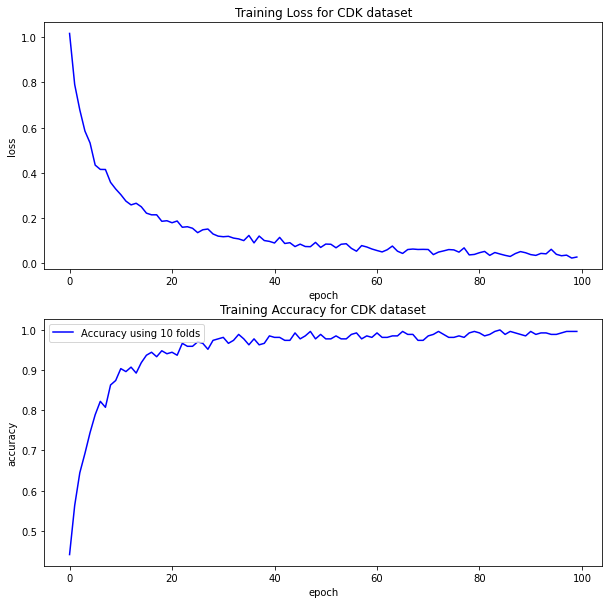

In [12]:
# Alina CIOCARLAN

loss= history.history['loss']
acc= history.history['accuracy']

# plot figures to compare performance between 10-fold crossval or 5-fold crossaval
plt.figure(figsize = (10, 10))
plt.subplot(2, 1, 1)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(loss, 'b', label='Loss using 10 folds')
plt.title("Training Loss for CDK dataset")

plt.subplot(2, 1, 2)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(acc, 'b', label='Accuracy using 10 folds')
plt.title("Training Accuracy for CDK dataset")
plt.legend()

plt.show()

### b. Banknote Dataset

In [11]:
# TESTS ON BANKNOTE DATASET

# Alina CIOCARLAN
# pre processing
banknote_pd_data = clean_dataframe(banknote_pd_data)

# feature selection
df_proj_bank=PCA_on_df(banknote_pd_data,0.97)

# split dataset kidney disease
dataX=np.array(df_proj_bank)
dataY=np.array(banknote_pd_data['class'])
train_ratio = 0.75
folds=10
# fine tuning
# get best params
kdn_x_train, kdn_x_test, kdn_y_train, kdn_y_test=data_split(dataX,dataY,train_ratio)
batch, epoch = get_best_epoch_batch(kdn_x_train,kdn_y_train)
optimizer = get_best_optimizer(kdn_x_train,kdn_y_train)

# get best model performing K-fold cross validation
best_model, bank_history = K_fold_cross_val(kdn_x_train,kdn_y_train, batch, epoch, optimizer,folds)

# evaluate this model
bank_loss_10, bank_acc_10 = best_model_fit_eval(best_model,kdn_x_train,kdn_y_train,kdn_x_test,kdn_y_test, batch, epoch, optimizer)

Looking for best epoch number and batch size.......
Best: 0.955292 using {'batch_size': 100, 'epochs': 150}
Looking for the best optimizer.......
Best: 0.965015 using {'optimizer': 'Adam'}
Looking for the best model using the best parameters.......
------------------------------------------------------------------------
Training for fold 1 ...
Train on 926 samples
Epoch 1/150
926/926 [==============================] - 1s 553us/sample - loss: 0.7212 - accuracy: 0.5778
Epoch 2/150
926/926 [==============================] - 0s 30us/sample - loss: 0.4886 - accuracy: 0.7559
Epoch 3/150
926/926 [==============================] - 0s 29us/sample - loss: 0.3899 - accuracy: 0.8067
Epoch 4/150
926/926 [==============================] - 0s 30us/sample - loss: 0.3314 - accuracy: 0.8575
Epoch 5/150
926/926 [==============================] - 0s 30us/sample - loss: 0.2943 - accuracy: 0.8747
Epoch 6/150
926/926 [==============================] - 0s 33us/sample - loss: 0.2709 - accuracy: 0.8877
Epoch 7/

Plot the learning curves.

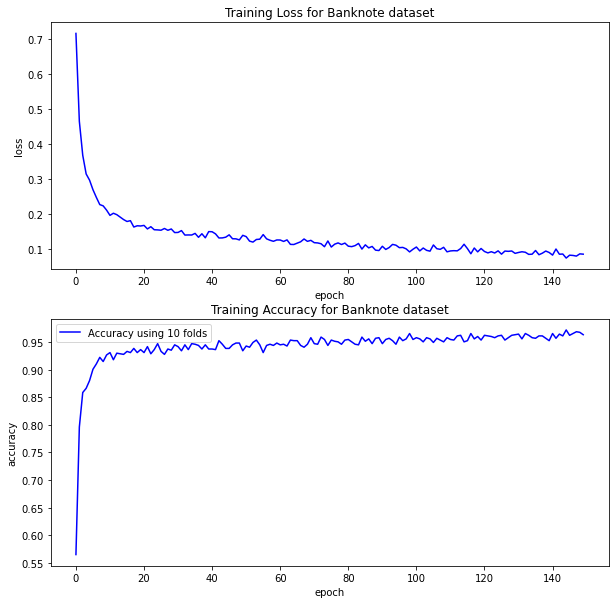

In [13]:
# Alina CIOCARLAN

loss= bank_history.history['loss']
acc= bank_history.history['accuracy']

# plot figures to compare performance between 10-fold crossval or 5-fold crossaval
plt.figure(figsize = (10, 10))
plt.subplot(2, 1, 1)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(loss, 'b', label='Loss using 10 folds')
plt.title("Training Loss for Banknote dataset")

plt.subplot(2, 1, 2)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(acc, 'b', label='Accuracy using 10 folds')
plt.title("Training Accuracy for Banknote dataset")
plt.legend()

plt.show()

In [20]:
# evaluate this model
bank_loss_bis, bank_acc_bis = best_model_fit_eval(best_model,kdn_x_train,kdn_y_train,kdn_x_test,kdn_y_test, batch, 1000, optimizer)

Training and evaluating the best model.......
Train on 1029 samples
Epoch 1/1000
1029/1029 [==============================] - 0s 56us/sample - loss: 0.0201 - accuracy: 0.9922
Epoch 2/1000
1029/1029 [==============================] - 0s 33us/sample - loss: 0.0113 - accuracy: 0.9942
Epoch 3/1000
1029/1029 [==============================] - 0s 36us/sample - loss: 0.0102 - accuracy: 0.9961
Epoch 4/1000
1029/1029 [==============================] - 0s 36us/sample - loss: 0.0102 - accuracy: 0.9971
Epoch 5/1000
1029/1029 [==============================] - 0s 38us/sample - loss: 0.0173 - accuracy: 0.9942
Epoch 6/1000
1029/1029 [==============================] - 0s 38us/sample - loss: 0.0160 - accuracy: 0.9951
Epoch 7/1000
1029/1029 [==============================] - 0s 40us/sample - loss: 0.0227 - accuracy: 0.9922
Epoch 8/1000
1029/1029 [==============================] - 0s 38us/sample - loss: 0.0212 - accuracy: 0.9913
Epoch 9/1000
1029/1029 [==============================] - 0s 40us/sample - l

Train on 689 samples, validate on 340 samples
Epoch 1/150
689/689 [==============================] - 0s 65us/sample - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.0267 - val_accuracy: 0.9941
Epoch 2/150
689/689 [==============================] - 0s 61us/sample - loss: 0.0115 - accuracy: 0.9956 - val_loss: 0.0277 - val_accuracy: 0.9941
Epoch 3/150
689/689 [==============================] - 0s 58us/sample - loss: 0.0086 - accuracy: 0.9971 - val_loss: 0.0275 - val_accuracy: 0.9941
Epoch 4/150
689/689 [==============================] - 0s 61us/sample - loss: 0.0075 - accuracy: 0.9985 - val_loss: 0.0275 - val_accuracy: 0.9941
Epoch 5/150
689/689 [==============================] - 0s 70us/sample - loss: 0.0180 - accuracy: 0.9942 - val_loss: 0.0299 - val_accuracy: 0.9912
Epoch 6/150
689/689 [==============================] - 0s 65us/sample - loss: 0.0104 - accuracy: 0.9942 - val_loss: 0.0293 - val_accuracy: 0.9941
Epoch 7/150
689/689 [==============================] - 0s 63us/sample - loss: 

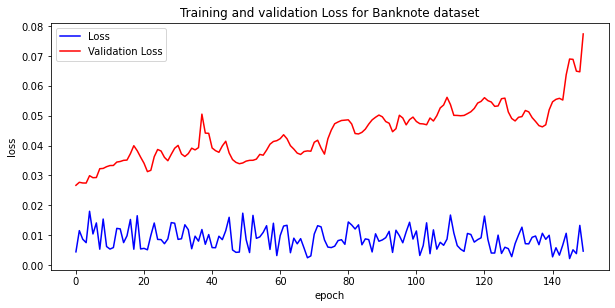

In [24]:

history_best_model = best_model.fit(kdn_x_train, kdn_y_train, validation_split=0.33,epochs=epoch, batch_size=batch)
loss = history_best_model.history['loss']
acc=history_best_model.history['accuracy']
val_loss=history_best_model.history['val_loss']
val_acc=history_best_model.history['val_accuracy']

plt.figure(figsize = (10, 10))
plt.subplot(2, 1, 1)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(loss, 'b', label='Loss')
plt.plot(val_loss, 'r', label='Validation Loss')
plt.title("Training and validation Loss for Banknote dataset")
plt.legend()
#       # evaluate and get metrics
# scores = model.evaluate(x_test, y_test, verbose=0)
# y_pred=model.predict_classes(x_test)